# ANALYSIS AND DESIGN OF CLOSED LOOP SYSTEMS

This notebook discusses the relationships between transfer functions in a closed loop system
and theory-based approaches to closed loop design using transfer functions.

# Preliminaries

In [7]:
import control
import controlSBML as ctl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tellurium as te
from IPython.display import Image

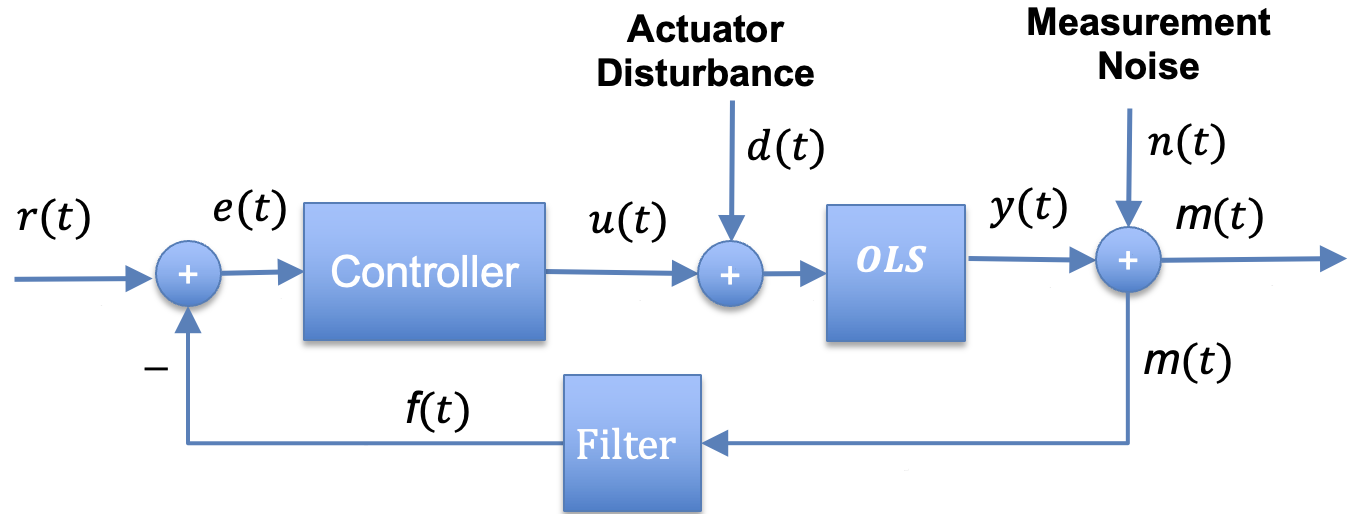

In [2]:
Image("closed_loop_system.png", width = 600, height = 300)

The starting point for transfer function analysis is to identify the system or systems to
be analyzed.
Here, we only consider single input single output (SISO) systems.
So, we need to identify which input/output relationships are of interest.

| Input  | Output | Why of interest?        | Desired DC Gain | Desired poles |
|--------|--------|-------------------------|-----------------|---------------|
| $r(t)$ | $m(t)$ | convergence to set point| 1               | very negative |
| $n(t)$ | $m(t)$ | influence of noise      | 0               | very negative |
| $d(t)$ | $m(t)$ | influence of disturbance| 0               | very negative |
| $r(t)$ | $e(t)$ | convergence to set point| 0               | very negative |
| $n(t)$ | $e(t)$ | influence of noise      | 0               | very negative |
| $d(t)$ | $e(t)$ | influence of disturbance| 0               | very negative |

Some other considerations:
1. Will the OLS always be within the operating region we designed for its input?
1. What are the maximum magnitudes of $d(t)$ and $n(t)$?
1. What trade-offs can we accepts?
    1. Achieved desired DC Gain but have oscillations? 
    1. Achieved desired DC Gain but have longer settling times?

# Helpers

In [3]:
TIMES = np.linspace(0, 10, 100)

In [4]:
TEST_MODEL = """
species S1, S2, S3

S1 -> S2; k1*S1
S2 -> S3; k2*S2

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 =2
"""
ctlsb = ctl.ControlSBML(TEST_MODEL, input_names=["S1", "S2"], output_names=["S3"])
TEST_SYS = ctlsb.makeNonlinearIOSystem("TEST_SYS")

In [5]:
class PlotResult(object):
    def __init__(self, times = None, y_arr=None, ax=None):
        self.times = times
        self.y_arr = y_arr
        self.ax = ax
        
    def __repr__(self):
        return ""

## ``plotSys``

In [6]:
def plotSys(sys, times=None, initial_values=None, forced_input=None,
            title="", ax=None, output_labels=None, figsize=None,
            ylim=None, is_legend=True, is_plot=True):
    """
    Plots the system, either a NonlinearIOSystem or a TransferFunction.
    
    Parameters
    ----------
    sys: NonlinearIOSystem or TransferFunction
    times: list-float (times for simulation)
    initial_values: list-float
    forced_input: list-float
    figsize: (int, int)
    ax: matplotlib.Axes
    output_labels: list-str (names for output labels)
    title: str (plot title)
    is_legend: bool (include legend)
    
    Returns
    -------
    PlotResut
    """
    if "NonlinearIOSystem" in str(type(sys)):
        is_nonlinear = True
    else:
        is_nonlinear = False
    if times is None:
        times = TIMES
    if forced_input is None:
        ncol = len(times)
        nrow = len(sys.input_labels)
        forced_input = np.array([np.repeat(0, nrow) for _ in range(ncol)])
        forced_input = np.reshape(forced_input, (nrow, ncol))
    if (initial_values is None) and is_nonlinear:
        initial_values = ctl.makeStateVector(sys)
    if figsize is None:
        figsize = (5, 5)
    if ax is None:
        _, ax = plt.subplots(1, figsize=figsize)
    if output_labels is None:
        output_labels = list(sys.output_labels)
    # Simulate the system
    if is_nonlinear:
        t, y = control.input_output_response(sys, times, forced_input, initial_values)
    else:
        t, y = control.forced_response(sys, T=times, U=forced_input)
    # Plot the response
    num_output = len(output_labels)
    if num_output == 1:
        if y.ndim == 1:
            plt.plot(t, y)
        else:
            plt.plot(t, y[0])
    else:
        for idx in range(num_output):
            ax.plot(t, y[idx])
    if is_legend:
        ax.legend(output_labels)
    ax.set_xlabel("time")
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(ylim)
    if not is_plot:
        plt.close()
    return PlotResult(times=t, y_arr=y, ax=ax)
    
# Tests
times = T = np.linspace(0, 70, 500)
plot_result = plotSys(TEST_SYS, times, is_plot=False)
assert(len(plot_result.times) == len(plot_result.y_arr[0]))
#
numerator = 5
tf = control.TransferFunction([numerator], [1])
plot_result = plotSys(tf, times, forced_input=1, is_plot=False)
assert(len(plot_result.times) == len(plot_result.y_arr))
assert(plot_result.y_arr[0] == numerator)
print("OK!")

OK!


# Models

## Linear

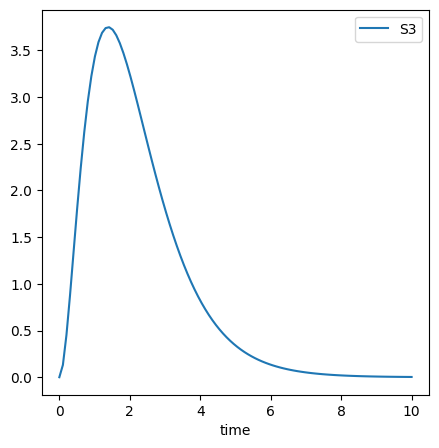

In [7]:
LINEAR_MDL = """
S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 -> S4; k3*S3

k1 = 2
k2 = 1.5
k3 = 1
S1 = 10
S2 = 0
S3 = 0
S4 = 0
"""
ctlsb = ctl.ControlSBML(LINEAR_MDL, input_names=["S1"], output_names=["S3"])
LINEAR_BLDR = ctlsb.makeSISOTransferFunctionBuilder(system_name="linear_sys")
_ = plotSys(LINEAR_BLDR.sys)

## Wolf

In [8]:
ctlsb = ctl.ControlSBML("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml", 
                        input_names=["at"], output_names=["s5"])
WOLF_BLDR = ctlsb.makeSISOTransferFunctionBuilder(system_name="wolf_sys")
_ = plotSys(WOLF_BLDR.sys)

NameError: name 'plotSys' is not defined

In [9]:
print(ctlsb.antimony)

// Created by libAntimony v2.13.2
model *Wolf2000_Glycolytic_Oscillations()

  // Compartments and Species:
  compartment compartment_;
  species s1 in compartment_, at_ in compartment_, s2 in compartment_, s3 in compartment_;
  species na in compartment_, s4 in compartment_, s5 in compartment_, s6 in compartment_;
  species s6o in compartment_;

  // Reactions:
  v1: s1 + 2 at_ -> s2; compartment_*k1*s1*at_/(1 + (at_/ki)^n);
  v2: s2 -> 2 s3; compartment_*k2*s2;
  v3: s3 + na -> s4 + at_; compartment_*((k31*k32*s3*na*(atot - at_) - k33*k34*s4*at_*(ntot - na))/(k33*(ntot - na) + k32*(atot - at_)));
  v4: s4 -> s5 + at_; compartment_*k4*s4*(atot - at_);
  v5: s5 -> s6; compartment_*k5*s5;
  v7: at_ -> ; compartment_*k7*at_;
  v8: s3 -> na; compartment_*k8*s3*(ntot - na);
  v9: s6o -> ; compartment_*k9*s6o;
  v10: s6 -> 0.1 s6o; compartment_*k10*(s6 - s6o);
  v6: s6 -> na; compartment_*k6*s6*(ntot - na);
  v0:  -> s1; compartment_*k0;

  // Species initializations:
  s1 = 1;
  at_ = 2;
 

# Other Transfer Functions for a Closed Loop System

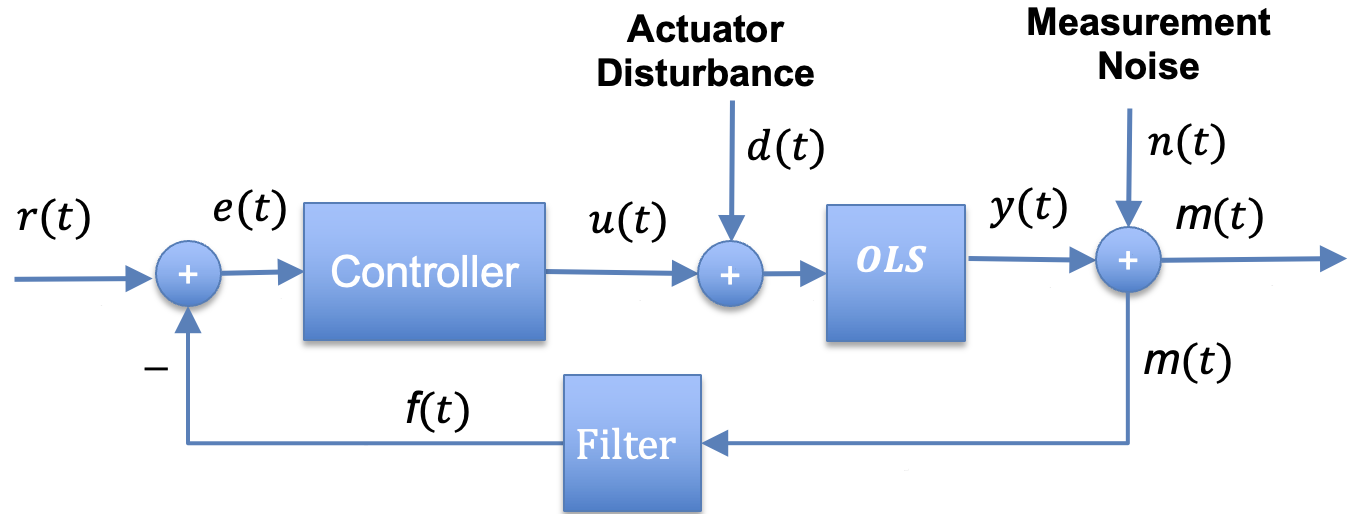

In [4]:
Image("closed_loop_system.png", width = 300, height = 150)

Define the transfer functions:
* $G_C (s)$: controller
* $G_F (s)$: filter
* $G_O (s)$: open loop system

Define the signals
* $R(s)$: reference input (set point)
* $D(S)$: disturbance
* $N(s)$: noise

## Steps for constructing a transfer function from existing system elements
1. Write equations that contain the input and output signals.
1. Construct a single equation that contains only the input and output.
1. Solve for the transfer function.

## Transfer function from Noise to System Output

Find the transfer function from $n(t)$ to $m(t)$.
That is, $G_{NM} = \frac{M(s)}{N(s)}$.

This transfer function assumes
that $r(t) = 0 = d(t)$.

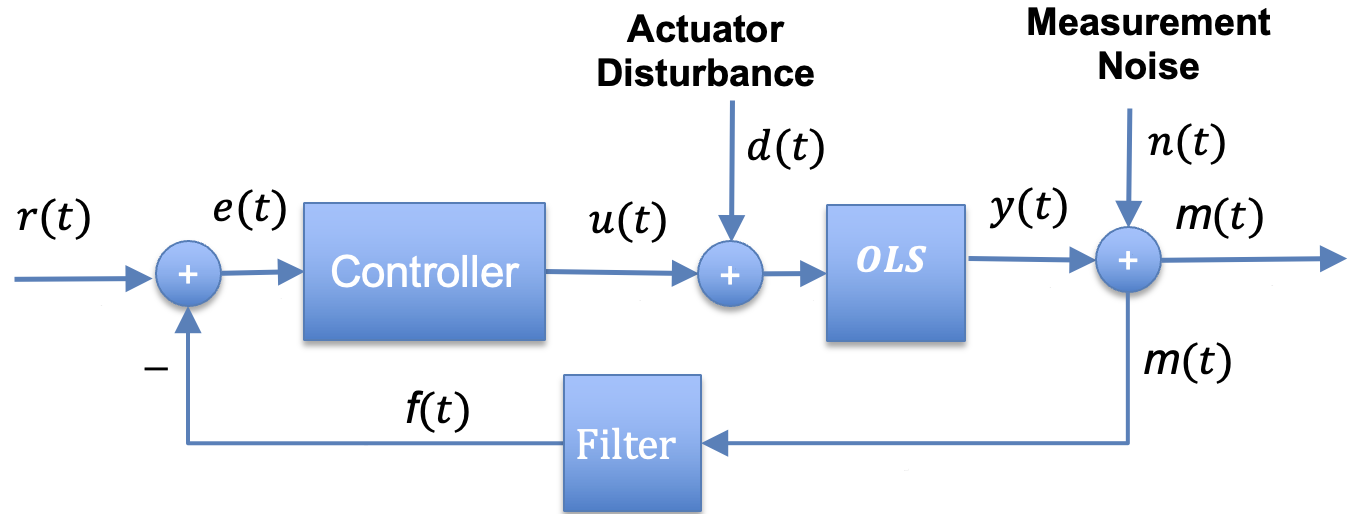

In [16]:
Image("closed_loop_system.png", width = 300, height = 150)

### 1. Write the relevant equations

1. $M(s) = E(s) G_C (s) G_O(s)$
1. $E(s) = R(s) - M(s) G_F(s)$

### 2. Construct a single equation that contains only the input and output

Substituting the second equation into the first:

\begin{eqnarray}
M(s) & = & E(s) G_C (s) G_O(s) \\
M(s)&  =& (R(s) - M(s) G_F(s) ) G_C (s) G_O(s) \\
M(s) ( 1 + G_C (s) G_O (s) G_F (s) )&  = & R(s) G_C (s) G_O(s) \\
G_{RM} (s) & = & \frac{M(s)}{R(s)} \\
& = & \frac{ G_C (s) G_O(s) }{1 + G_C (s) G_O(s) G_F(s)} \\
\end{eqnarray}

### 3. Solve for the transfer function

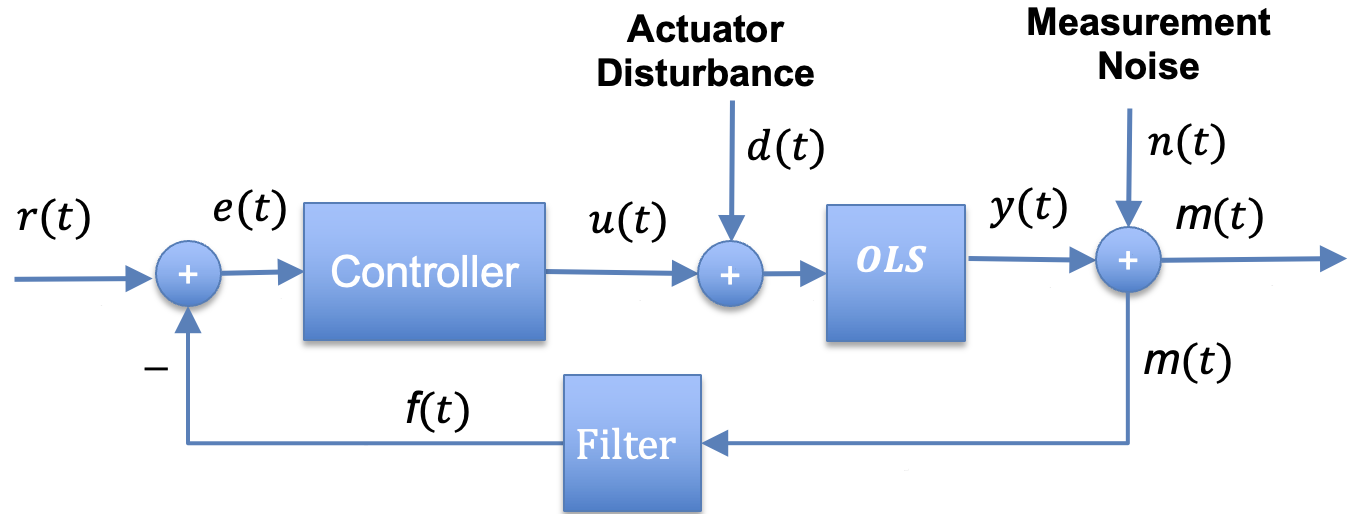

In [17]:
Image("closed_loop_system.png", width = 300, height = 150)

## Questions
1. What is the DC Gain of $G_{RM} (s)$? 
   1. Suppose $G_C (0 ) = 0 = G_O (0)$.
   1. For the following, $G_C (0 ) \neq 0 \neq G_O (0)$.
       1. $G_F (0) = 1$
       1. $G_F (0) \neq 1$
1. Repeat this question for the case where $G_C (s) = k_P + \frac{k_I}{s}$, integral control. 

# Exercise: Constructing closed loop transfer functions

## Linear model

Consider a closed loop system in which there is no filter.

Find $G_{RM}$ for a PI controller where $k_I = 0.1$ and $k_P = 1$.

$G_{RM} = \frac{ G_C (s) G_O(s) }{1 + G_C (s) G_O(s) G_F(s)}$

**Hints**
1. Find $G_O(s)$
1. Write the equations for the other transfer functions
1. Use algebra on transfer functions to find $G_{RM}$

## Wolf model

The closed loop system includes a filter with $k_F = 1$ and the
same PI controller as used above.

$G_{RM} = $?